In [1]:
!pip install git+https://github.com/RobustBench/robustbench.git
!git clone https://github.com/kentaroy47/vision-transformers-cifar10.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-1qte704w
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-1qte704w
  Resolved https://github.com/RobustBench/robustbench.git to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-4d5q59jc/autoattack_65f06d5cb51a415bb159238209c59424
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-4d5q59jc/autoattack_65f06d5cb51a415bb159238209c59424
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [28]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Define project path
drive_path = '/content/drive/My Drive/Paper/Robustness Image Classification/'

Mounted at /content/drive


In [30]:
# Constants
# EPOCHS = 50
# LR = 0.01
# NUM_CLASSES = 10
# BATCH_SIZE = 32
# IMG_SIZE = 224
EPOCHS = 20
LR = 1e-4
NUM_CLASSES = 10
BATCH_SIZE = 100
IMG_SIZE = 384
size = 384
patch = 4
dimhead = 512
convkernel = 8
ROOT_DATA = './data'
CIFAR10_CORRUPT_PATH = f'{drive_path}Dataset/CIFAR-10-C'

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

corruption_types = [
    'brightness', 'contrast', 'defocus_blur', 'elastic_transform',
    'fog', 'frost', 'gaussian_blur', 'gaussian_noise',
    'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur',
    'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter',
    'speckle_noise', 'zoom_blur'
]

In [5]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TrF
import argparse, math, os, random, sys, torch, torchvision, time, timm
from PIL import Image
from collections import OrderedDict
from robustbench.data import load_cifar10c
from torch.utils.data import TensorDataset, Dataset, DataLoader, SubsetRandomSampler

import sys
sys.path.append('/content/vision-transformers-cifar10')
from models import *

# Read & Plot Data

1. Implementasi Data/Image Preprocessing

Dataset CIFAR-10 merupakan dataset yang dibentuk oleh tim riset University of Toronto https://www.cs.toronto.edu/~kriz/cifar.html, terdiri dari 60,000 gambar RGB (50,000 train dan 10,000 test) berdimensi 32x32. CIFAR-10 memiliki 10 kelas / kategori objek: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

a. Tipe data yang digunakan

Array numpy yang berisi data gambar mentah yang jika dilihat berukuran 32x32, selanjutnya dilakukan preprocessing sehingga didapatkan:

trainloader, testloader

b. Pra-pemrosesan data yang dilakukan

Dataset yang diload dari PyTorch secara langsung lalu diolah dan ditransformasi. Transformasi yang didefinisikan meliputi proses seperti pemangkasan acak (random crop) dengan padding 4 piksel, flipping horizontal secara acak, dan mengubah data menjadi tensor (untuk data train dan testing). Ukuran batch pada train yaitu 128, serta 100 pada data testing. Data train dilakukan shuffle, sedangkan data testing tidak

In [6]:
class RandomImageTransform(object):
    def __init__(self, impulse_prob=0.1, gauss_prob=0.1, contrast_prob=0.1, fog_prob=0.1, noise_prob=0.01, amplitude=10000, noise_std=0.05, contrast_range=(0.5, 1.5), fog_density=0.5):
        self.impulse_prob = impulse_prob
        self.gauss_prob = gauss_prob
        self.contrast_prob = contrast_prob
        self.fog_prob = fog_prob
        self.noise_prob = noise_prob
        self.amplitude = amplitude
        self.noise_std = noise_std
        self.contrast_range = contrast_range
        self.fog_density = fog_density

    def __call__(self, img):
        transform_prob = random.random()
        if transform_prob < self.contrast_prob:
            img = self.apply_contrast(img)
        elif transform_prob < self.contrast_prob + self.gauss_prob:
            img = self.apply_gaussian_noise(img)
        elif transform_prob < self.contrast_prob + self.gauss_prob + self.impulse_prob:
            img = self.apply_impulse_noise(img)
#         elif transform_prob < self.contrast_prob + self.gauss_prob + self.impulse_prob + self.fog_prob:
#             img = self.apply_fog(img)
        return img

    def apply_impulse_noise(self, img):
        noise_mask = torch.rand_like(img)
        salt = (noise_mask < self.noise_prob / 2).float()
        pepper = (noise_mask > 1 - self.noise_prob / 2).float()

        noisy_img = img.clone()
        noisy_img += salt * 255.0 * 2 * self.amplitude
        noisy_img -= pepper * 255.0 * 2 * self.amplitude
        noisy_img = torch.clamp(noisy_img, 0, 255)
        return noisy_img

    def apply_gaussian_noise(self, img):
        noise = torch.randn_like(img) * self.noise_std
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0, 1)
        return noisy_img

    def apply_contrast(self, img):
        factor = random.uniform(*self.contrast_range)
        mean = torch.mean(img)
        img = (img - mean) * factor + mean
        img = torch.clamp(img, 0, 255)
        return img

    def apply_fog(self, img):
        fog_density = torch.randn_like(img) * self.noise_std + self.fog_density
        fog_density = torch.clamp(fog_density, 0, 1)  # Ensure values are between 0 and 1

        # Add fog to the image
        img = img * (1 - fog_density) + fog_density
        img = torch.clamp(img, 0, 1)  # Ensure values are between 0 and 1
        return img

In [7]:
# Melakukan pembacaan data dari sumber, serta melakukan preprocessing
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    RandomImageTransform(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(
    root=ROOT_DATA, train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root=ROOT_DATA, train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

==> Preparing data..


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


In [8]:
print("Train set size:", len(trainloader.dataset))
print("Test set size:", len(testloader.dataset))

Train set size: 50000
Test set size: 10000


In [9]:
# Plot gambar per kelas
def plot_cifar10(cifar_dataset, data_title, num_images_per_class=5):
    classes = cifar_dataset.classes
    class_indices = {class_name: [] for class_name in classes}

    # Memuat indeks sampel untuk setiap kelas
    for i, (_, label) in enumerate(cifar_dataset):
        class_name = classes[label]
        if len(class_indices[class_name]) < num_images_per_class:
            class_indices[class_name].append(i)

        # Keluar dari loop jika semua kelas sudah memiliki sampel yang cukup
        if all(len(indices) == num_images_per_class for indices in class_indices.values()):
            break

    fig, axes = plt.subplots(nrows=len(classes), ncols=num_images_per_class, figsize=(10, 20))

    # Memuat dan menampilkan gambar
    for i, class_name in enumerate(classes):
        for j in range(num_images_per_class):
            index = class_indices[class_name][j]
            image, _ = cifar_dataset[index]
            axes[i, j].imshow(image.permute(1, 2, 0))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_title(class_name)

    plt.suptitle(f'Plot CIFAR10 | {num_images_per_class} Examples ({data_title})', y=1)
    plt.tight_layout()
    plt.show()

plot_cifar10(trainloader.dataset,'Train')
plot_cifar10(testloader.dataset,'Test')

Output hidden; open in https://colab.research.google.com to view.

# Pembangunan Arsitektur Model

In [10]:
# !pip install pretrainedmodels

In [11]:
# import pretrainedmodels
# import ssl
# from timm import create_model

In [12]:
# def custom_model():
#     # Define the resnet model
# #     ssl._create_default_https_context = ssl._create_unverified_context
# #     model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
#     model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
# #     model = torchvision.models.efficientnetb0(weights='IMAGENET1K_V1')

# #     for param in model.parameters():
# #         param.requires_grad = False

#     # Update the fully connected layer of resnet with our current target of 10 desired outputs
#     model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

# #     model = create_model('efficientnet_b0', pretrained=True)
# #     for param in model.parameters():
# #         param.requires_grad = False
#     # Make the parameters of certain layers trainable
# #     for name, param in model.named_parameters():
# #         if 'classifier' in name:  # Modify this condition as per your requirement
# #             param.requires_grad = True  # Unfreeze the parameters of the classifier layer
# #     model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)

# #     model = pretrainedmodels.__dict__["inceptionresnetv2"](pretrained='imagenet')
# #     model.last_linear = nn.Linear(model.last_linear.in_features, NUM_CLASSES)

#     return model

In [13]:
def custom_model(model_name='resnet34'):
    if model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet50':
        model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet101':
        model = torchvision.models.resnet101(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet152':
        model = torchvision.models.resnet152(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'wide_resnet50_2':
        model = torchvision.models.wide_resnet50_2(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'wide_resnet101_2':
        model = torchvision.models.wide_resnet101_2(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'mnasnet1_0':
        model = torchvision.models.mnasnet1_0(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'alexnet':
        model = torchvision.models.alexnet(pretrained=True)
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
    elif model_name == 'googlenet':
        model = torchvision.models.googlenet(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'vgg16':
        model = torchvision.models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CLASSES)
    elif model_name == 'inception_v3':
        model = torchvision.models.inception_v3(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'mobilenetv2':
        model = torchvision.models.mobilenet_v2(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'mobilenetv3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        print(model.classifier)
        model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
    elif model_name == 'mobilenetv3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
        model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
    elif model_name == 'densenet121':
        model = torchvision.models.densenet121(pretrained=True)
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'densenet161':
        model = torchvision.models.densenet161(pretrained=True)
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'densenet169':
        model = torchvision.models.densenet169(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'densenet201':
        model = torchvision.models.densenet201(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'squeezenet1_0':
        model = torchvision.models.squeezenet1_0(pretrained=True)
        model.classifier[1] = torch.nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
    elif model_name == 'squeezenet1_1':
        model = torchvision.models.squeezenet1_1(pretrained=True)
        model.classifier[1] = torch.nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
    elif model_name == 'resnext50_32x4d':
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'shufflenet_v2_x1_0':
        model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'vit_b_16':
        model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_b_32':
        model = torchvision.models.vit_b_32(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_h_14':
        model = torchvision.models.vit_h_14()
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_l_16':
        model = torchvision.models.vit_l_16(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_l_32':
        model = torchvision.models.vit_l_32(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == "vit_timm":
        model = timm.create_model("vit_base_patch16_384", pretrained=True)
        model.head = nn.Linear(model.head.in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b0':
        model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b1':
        model = torchvision.models.efficientnet_b1(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b2':
        model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b3':
        model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b4':
        model = torchvision.models.efficientnet_b4(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b5':
        model = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b6':
        model = torchvision.models.efficientnet_b6(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b7':
        model = torchvision.models.efficientnet_b7(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    else:
        raise ValueError("Invalid model name! Supported models: vgg, inception, mobilenet, densenet, squeezenet, resnext, nasnet, xception, shufflenet")

    return model

In [14]:
# !pip install einops

# import torch.nn.functional as F
# from typing import Callable
# from einops import rearrange, reduce, repeat

# class ConvTokenizer(nn.Module):
#     def __init__(
#         self,
#         channels: int = 3, emb_dim: int = 256,
#         conv_kernel: int = 3, conv_stride: int = 2, conv_pad: int = 3,
#         pool_kernel: int = 3, pool_stride: int = 2, pool_pad: int = 1,
#         activation: Callable = nn.ReLU
#     ):
#         super().__init__()
#         self.conv = nn.Conv2d(
#             in_channels=channels, out_channels=emb_dim,
#             kernel_size=conv_kernel, stride=conv_stride,
#             padding=(conv_pad, conv_pad)
#         )
#         self.act = activation(inplace=True)
#         self.max_pool = nn.MaxPool2d(
#             kernel_size=pool_kernel, stride=pool_stride,
#             padding=pool_pad
#         )

#     def forward(self, x: torch.Tensor):
#         x = self.conv(x)
#         x = self.act(x)
#         x = self.max_pool(x)
#         return x

In [15]:
# class TransformerEncoderBlock(nn.Module):
#     """Transformer Encoder Block"""

#     def __init__(
#         self, n_h: int, emb_dim: int, feat_dim: int,
#         dropout: float = 0, attention_dropout: float = 0
#     ):
#         super().__init__()
#         self.msa = MSA(heads=n_h, emb_dim=emb_dim, dropout=dropout, attention_dropout=attention_dropout)
#         self.norm1 = nn.LayerNorm(emb_dim)
#         self.ffn = MLP(emb_dim, feat_dim, dropout)
#         self.norm2 = nn.LayerNorm(emb_dim)

#     def forward(self, x: torch.Tensor):
#         identity = x
#         x = self.msa(x)
#         x += identity
#         x = self.norm1(x)
#         identity = x
#         x = self.ffn(x)
#         x += identity
#         x = self.norm2(x)
#         return x

In [16]:
# class MSA(nn.Module):
#     """Multi-head Self Attention Block"""

#     def __init__(
#         self, heads: int, emb_dim: int,
#         dropout: float = 0., attention_dropout: float = 0.
#     ):
#         super().__init__()
#         self.emb_dim = emb_dim
#         self.n_h = heads
#         self.head_dim = self.emb_dim // self.n_h
#         self.q = nn.Linear(self.emb_dim, self.emb_dim)
#         self.k = nn.Linear(self.emb_dim, self.emb_dim)
#         self.v = nn.Linear(self.emb_dim, self.emb_dim)
#         self.attention_dropout = nn.Dropout(attention_dropout)
#         self.linear_projection = nn.Linear(self.emb_dim, self.emb_dim)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x: torch.Tensor):
#         # (bs,     s_l,      e_d)
#         batch_s, seq_len, emb_dim = x.shape
#         # (bs, s_l, e_d) -> (bs, s_l, n_h, h_d) -> (bs, n_h, s_l, h_d)
#         x_q = self.q(x).view(
#             batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
#         x_k = self.k(x).view(
#             batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
#         x_v = self.v(x).view(
#             batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
#         # @ operator is the convention for matrix multiplication, throughout python
#         # q @ k.T -> (bs, n_h, s_l, h_d) @ (bs, n_h, h_d, s_l) -> (bs, n_h, s_l, s_l)
#         # Softmax((q @ k.T)/root(h_d)) @ v
#         #   -> (bs, n_h, s_l, s_l) @ (bs, n_h, s_l, h_d) -> (bs, n_h, s_l, h_d)
#         attention = (x_q @ x_k.transpose(-2, -1)) / math.sqrt(x_q.size(-1))
#         attention = F.softmax(attention, dim=-1)
#         attention = self.attention_dropout(attention)
#         # (bs, n_h, s_l, h_d) -> (bs, s_l, n_h, h_d) -> (bs, s_l, e_d)
#         x = (attention @ x_v).transpose(1, 2).reshape(batch_s, seq_len, emb_dim)
#         x = self.linear_projection(x)
#         x = self.dropout(x)
#         return x

In [17]:
# class MLP(nn.Module):
#     """MLP block"""

#     def __init__(self, emb_dim: int, feat_dim: int, dropout: float = 0):
#         super().__init__()
#         self.layer1 = nn.Linear(emb_dim, feat_dim)
#         self.activation = nn.GELU()
#         self.dropout = nn.Dropout(dropout)
#         self.layer2 = nn.Linear(feat_dim, emb_dim)

#         # below init from torchvision
#         nn.init.xavier_uniform_(self.layer1.weight)
#         nn.init.xavier_uniform_(self.layer2.weight)
#         nn.init.normal_(self.layer1.bias, std=1e-6)
#         nn.init.normal_(self.layer2.bias, std=1e-6)

#     def forward(self, x: torch.Tensor):
#         x = self.layer1(x)
#         x = self.activation(x)
#         x = self.dropout(x)
#         x = self.layer2(x)
#         x = self.dropout(x)
#         return x

In [18]:
# class SeqPool(nn.Module):
#     def __init__(self, emb_dim=256):
#         super().__init__()
#         self.dense = nn.Linear(emb_dim, 1)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x):
#         bs, seq_len, emb_dim = x.shape
#         identity = x
#         x = self.dense(x)
#         x = rearrange(
#             x, 'bs seq_len 1 -> bs 1 seq_len', seq_len=seq_len
#         )
#         x = self.softmax(x)
#         x = x @ identity
#         x = rearrange(
#             x, 'bs 1 e_d -> bs e_d', e_d=emb_dim
#         )
#         return x

In [19]:
# class CCT(nn.Module):
#     """
#         Compact Convolutional Transformer (CCT) Model
#         https://arxiv.org/abs/2104.05704v4
#     """
#     def __init__(
#         self,
#         conv_kernel: int = 3, conv_stride: int = 2, conv_pad: int = 3,
#         pool_kernel: int = 3, pool_stride: int = 2, pool_pad: int = 1,
#         heads: int = 4, emb_dim: int = 256, feat_dim: int = 2*256,
#         dropout: float = 0.1, attention_dropout: float = 0.1, layers: int = 7,
#         channels: int = 3, image_size: int = 32, num_class: int = 10
#     ):
#         super().__init__()
#         self.emb_dim = emb_dim
#         self.image_size = image_size

#         self.tokenizer = ConvTokenizer(
#             channels=channels, emb_dim=self.emb_dim,
#             conv_kernel=conv_kernel, conv_stride=conv_stride, conv_pad=conv_pad,
#             pool_kernel=pool_kernel, pool_stride=pool_stride, pool_pad=pool_pad,
#             activation=nn.ReLU
#         )

#         with torch.no_grad():
#             x = torch.randn([1, channels, image_size, image_size])
#             out = self.tokenizer(x)
#             _, _, ph_c, pw_c  = out.shape

#         self.linear_projection = nn.Linear(
#             ph_c, pw_c, self.emb_dim
#         )

#         self.pos_emb = nn.Parameter(
#             torch.randn(
#                 [1, ph_c*pw_c, self.emb_dim]
#             ).normal_(std=0.02) # from torchvision, which takes this from BERT
#         )
#         self.dropout = nn.Dropout(dropout)
#         encoders = []
#         for _ in range(0, layers):
#             encoders.append(
#                 TransformerEncoderBlock(
#                     n_h=heads, emb_dim=self.emb_dim, feat_dim=feat_dim,
#                     dropout=dropout, attention_dropout=attention_dropout
#                 )
#             )
#         self.encoder_stack = nn.Sequential(*encoders)
#         self.seq_pool = SeqPool(emb_dim=self.emb_dim)
#         self.mlp_head = nn.Linear(self.emb_dim, num_class)


#     def forward(self, x: torch.Tensor):
#         bs, c, h, w = x.shape  # (bs, c, h, w)

#         # Creates overlapping patches using ConvNet
#         x = self.tokenizer(x)
#         x = rearrange(
#             x, 'bs e_d ph_h ph_w -> bs (ph_h ph_w) e_d',
#             bs=bs, e_d=self.emb_dim
#         )

#         # Add position embedding
#         x = self.pos_emb.expand(bs, -1, -1) + x
#         x = self.dropout(x)

#         # Pass through Transformer Encoder layers
#         x = self.encoder_stack(x)

#         # Perform Sequential Pooling <- Novelty of the paper
#         x = self.seq_pool(x)

#         # MLP head used to get logits
#         x = self.mlp_head(x)

#         return x

In [20]:
# def custom_model():
#     config = dict(
#         seed=42, # <-- the answer to life, the universe and everything
#         heads=4, emb_dim=256, feat_dim=512, layers=7,
#         num_class=NUM_CLASSES, image_size=IMG_SIZE,
#         dropout=0.5, attention_dropout=0.1,
#     )

#     model = CCT(
#         heads=config['heads'], emb_dim=config['emb_dim'],
#         feat_dim=config['feat_dim'], layers=config['layers'],
#         num_class=config['num_class'], image_size=config['image_size'],
#         dropout=config['dropout'], attention_dropout=config['attention_dropout']
#     )

#     return model

In [21]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         # Max pooling layers
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Fully connected layers
# #         self.fc1 = nn.Linear(128 * 4 * 4, 512)
#         self.fc1 = nn.Linear(128 * 8 * 8, 512)
#         self.fc2 = nn.Linear(512, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 4 * 4)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# def custom_model():
#     return CNN()

Secara ringkas, optimizer SGD digunakan untuk mengoptimalkan parameter-parameter model dengan mengurangi fungsi kerugian (loss function) selama pelatihan. Momentum dan weight decay digunakan untuk membantu percepatan konvergensi dan mencegah overfitting. Sementara itu, penjadwalan laju pembelajaran dengan penurunan kosinus memastikan bahwa laju pembelajaran dikurangi secara bertahap selama pelatihan, sehingga memungkinkan model untuk menemukan minimum global secara lebih stabil.

In [22]:
net = custom_model('vit_timm')
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=LR)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
n_epoch = EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [23]:
print(net)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Pelatihan Model

Dilakukan proses pelatihan dengan data latih bersumber dari trainloader, serta data validasi bersumber dari testloader. Pada setiap epoch, dipantau akurasi, loss, serta dicatat waktu pelatihannya. Kemudian dilakukan ploting terhadap loss dan akurasi selama fase pelatihan.

Referensi kode dengan modifikasi:

https://www.kaggle.com/code/luckily66/gpipe-of-monocnn101

In [24]:
best_acc = 0
start_epoch = 0
c_type_errors = {}

# Model
print('==> Building model..')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Use CUDA' if torch.cuda.is_available() else 'Use CPU')

net = net.to(device)
train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list = [],[],[],[]
# Training
def train(epoch):
    print('\nEpoch: {:d}  lr: {:.4f}'.format(epoch, scheduler.get_last_lr()[0]))
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, net.parameters()), max_norm=5)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    # Calculate and print average loss and accuracy for the epoch
    avg_loss = train_loss / len(trainloader)
    accuracy = 100. * correct / total
    train_accuracy_list.append(accuracy)
    train_loss_list.append(avg_loss)
    print('Train Loss: {:.3f} | Acc: {:.3f}% ({:d}/{:d})'.format(avg_loss, accuracy, correct, total))
    if torch.isnan(torch.tensor(avg_loss)):
        return True

    return False


def test(net, testloader, is_train = True):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    correct_sample_indices = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct_sample_indices.extend(predicted.eq(targets).cpu().detach().numpy().tolist())
            correct += predicted.eq(targets).sum().item()

            if total >= 10000:
                break
    accuracy = 100. * correct / total
    loss = test_loss / (batch_idx + 1)
    if(is_train):
        val_accuracy_list.append(accuracy)
        val_loss_list.append(loss)
    print('Test Loss: {:.3f} | Acc: {:.3f} ({:d}/{:d})'.format(loss, accuracy, correct, total))
    return accuracy, np.where(correct_sample_indices)[0]


save_data_dict = OrderedDict()
start_time = time.time()
for epoch in range(start_epoch, start_epoch+n_epoch):
    epoch_start_time = time.time()
    terminate = train(epoch)
    acc, sampler_indices = test(net, testloader)
    scheduler.step()
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Time elapsed: %.2f s' % epoch_time)
    if epoch == start_epoch+n_epoch-1:
        c_type_errors['original'] = 1-acc/100
    if terminate:
        break

save_data_dict['acc'] = acc
save_data_dict['state_dict'] = net.state_dict()
end_time = time.time()
training_time = end_time - start_time
print('\nFinished Training\nTotal Training Time: %.2f seconds' % training_time)

==> Building model..
Use CUDA

Epoch: 0  lr: 0.0001
Train Loss: 0.646 | Acc: 79.436% (39718/50000)
Test Loss: 0.059 | Acc: 98.320 (9832/10000)
Time elapsed: 1046.45 s

Epoch: 1  lr: 0.0001
Train Loss: 0.248 | Acc: 91.042% (45521/50000)
Test Loss: 0.048 | Acc: 98.580 (9858/10000)
Time elapsed: 1044.31 s

Epoch: 2  lr: 0.0001
Train Loss: 0.218 | Acc: 92.024% (46012/50000)
Test Loss: 0.042 | Acc: 98.730 (9873/10000)
Time elapsed: 1045.04 s

Epoch: 3  lr: 0.0001
Train Loss: 0.204 | Acc: 92.690% (46345/50000)
Test Loss: 0.040 | Acc: 98.790 (9879/10000)
Time elapsed: 1044.89 s

Epoch: 4  lr: 0.0001
Train Loss: 0.195 | Acc: 92.942% (46471/50000)
Test Loss: 0.040 | Acc: 98.810 (9881/10000)
Time elapsed: 1044.62 s

Epoch: 5  lr: 0.0001
Train Loss: 0.182 | Acc: 93.436% (46718/50000)
Test Loss: 0.040 | Acc: 98.830 (9883/10000)
Time elapsed: 1044.68 s

Epoch: 6  lr: 0.0001
Train Loss: 0.178 | Acc: 93.638% (46819/50000)
Test Loss: 0.039 | Acc: 98.880 (9888/10000)
Time elapsed: 1047.43 s

Epoch: 7  

3. Visualisasi Progress Pelatihan

In [25]:
# Save model ke file
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_acc': acc,
    'train_accuracy_list': train_accuracy_list,
    'val_accuracy_list': val_accuracy_list,
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
}, f'{drive_path}vit_timm_best_model.pth')

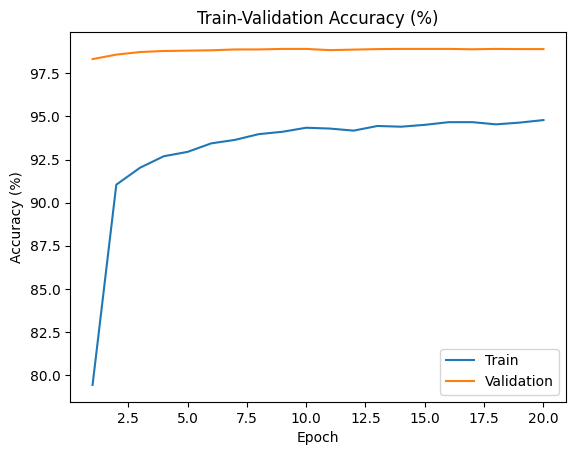

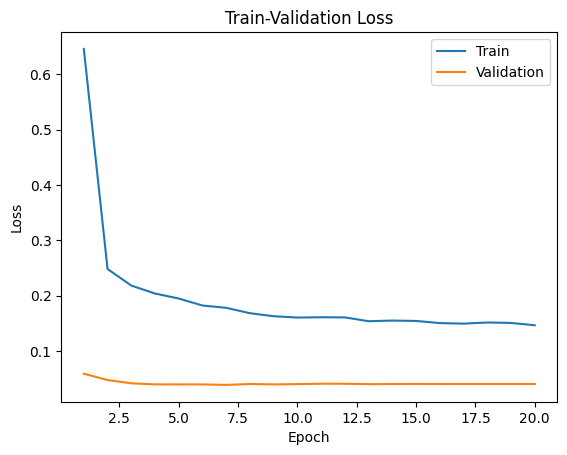

In [26]:
# Plot train and validation accuracy & loss
def plot_train_val(train_list, val_list, metric_type, EPOCHS):
    plt.plot(range(1, EPOCHS + 1), train_list, label='Train')
    plt.plot(range(1, EPOCHS + 1), val_list, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric_type)
    plt.title(f'Train-Validation {metric_type}')
    plt.legend()
    plt.savefig(f'{drive_path}train_val_{metric_type.lower()}.png')
    plt.show()

plot_train_val(train_accuracy_list, val_accuracy_list, 'Accuracy (%)', EPOCHS)
plot_train_val(train_loss_list, val_loss_list, 'Loss', EPOCHS)

# Pengujian dengan Dataset CIFAR10-Corrupted

CIFAR-10-C merupakan dataset yang dibentuk oleh (Hendrycks and Dietterich, ICLR2019) untuk melakukan benchmarking kehandalan berbagai deep learning classifiers terhadap berbagai kerusakan atau noise pada gambar objek.

CIFAR-10-C berasal dari sampel uji CIFAR-10 yang asli, lalu diberikan variasi dengan berbagai jenis kerusakan (corruption) dan tingkat severity. Terdapat 19 jenis keruasakan dan 5 tingkatan severity pada dataset CIFAR-10-C. Di sini digunakan data CIFAR-10-C yang diambil dari Kaggle, tetapi juga bersumber dari penelitian Hendrycks and Dietterich.

Jenis kerusakannya adalah sebagai berikut:

'brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur'

Selanjutnya dilakukan proses pengujian terhadap model yang telah dilatih sebelumnya. Pengujian menggunakan dataloader CIFAR-10-C untuk 19 kategori kerusakan dan dipantau loss serta akurasinya. Kemudian untuk semua jenis kerusakan tersebut, dilakukan ploting dan dihitung rata-rata error serta akurasinya.

In [31]:
# Membuat class CorruptedCIFAR
class CorruptedCIFAR(Dataset):
    def __init__(self, root, corruption_type = None, transform = None, target_transform = None):
        self.corrupted_data_root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.test_data = []
        self.test_labels = []
        if corruption_type is None:
            for c_type in self.corruption_types:
                self.test_data.append(np.load(os.path.join(self.corrupted_data_root, '{}.npy'.format(c_type))))
                self.test_labels += np.load(os.path.join(self.corrupted_data_root, 'labels.npy')).tolist()
        else:
            self.test_data.append(np.load(os.path.join(self.corrupted_data_root, '{}.npy'.format(corruption_type))))
            self.test_labels += np.load(os.path.join(self.corrupted_data_root, 'labels.npy')).tolist()
        self.test_data = np.concatenate(self.test_data, axis=0)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.test_data[index], self.test_labels[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.test_data)

    def __repr__(self):
        fmt_str = 'Dataset' + self.__class__.__name__ + '\n'
        fmt_str += ' Number of datapoints:{}\n'.format(self.__len__())
        tmp = 'test'
        fmt_str += ' Split:{}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.corrupted_data_root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

# Pembuatan instansiasi objek dari dataset CorruptedCIFAR
corrupt_testloaders = {}
for c_type in corruption_types:
    corrupt_testset = CorruptedCIFAR(root=CIFAR10_CORRUPT_PATH, corruption_type=c_type, transform=transform_test)
    corrupt_testloader = torch.utils.data.DataLoader(
        corrupt_testset, batch_size=100, shuffle=False, num_workers=4)
    corrupt_testloaders[c_type] = corrupt_testloader

In [ ]:
# Plot 1 contoh kelas CIFAR10 untuk 19 jenis corrupted image
num_images = len(corrupt_testloaders)
num_rows = math.ceil(num_images / 6)
num_cols = min(num_images, 6)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i, (c_type, testloader) in enumerate(corrupt_testloaders.items()):
    row = i // num_cols
    col = i % num_cols
    img, _ = next(iter(testloader))

    axes[row, col].imshow(img[0].permute(1, 2, 0))  # Permute dimensi gambar
    axes[row, col].axis('off')
    axes[row, col].set_title(c_type, size=11)

# Menyembunyikan subplot kosong
for i in range(num_rows * num_cols):
    if i >= num_images:
        row = i // num_cols
        col = i % num_cols
        axes[row, col].set_visible(False)

plt.suptitle(f'Plot CIFAR10-C for Cat')
plt.tight_layout()
plt.show()

In [33]:
# Melakukan evaluasi terhadap CIFAR10 Corrupted
print("Evaluating on corrupted CIFAR-10 testset\n")
for c_type in corruption_types:
    print('- corruption type: {}'.format(c_type))
    corrupt_acc, _ = test(net, corrupt_testloaders[c_type])
    c_type_errors[c_type] = 1-corrupt_acc/100
    save_data_dict['{}_acc'.format(c_type)] = corrupt_acc

Evaluating on corrupted CIFAR-10 testset

- corruption type: brightness
Test Loss: 0.040 | Acc: 98.940 (9894/10000)
- corruption type: contrast
Test Loss: 0.040 | Acc: 98.940 (9894/10000)
- corruption type: defocus_blur
Test Loss: 0.044 | Acc: 98.720 (9872/10000)
- corruption type: elastic_transform
Test Loss: 0.095 | Acc: 97.550 (9755/10000)
- corruption type: fog
Test Loss: 0.040 | Acc: 98.950 (9895/10000)
- corruption type: frost
Test Loss: 0.051 | Acc: 98.630 (9863/10000)
- corruption type: gaussian_blur
Test Loss: 0.044 | Acc: 98.750 (9875/10000)
- corruption type: gaussian_noise
Test Loss: 0.159 | Acc: 95.740 (9574/10000)
- corruption type: glass_blur
Test Loss: 0.541 | Acc: 86.180 (8618/10000)
- corruption type: impulse_noise
Test Loss: 0.067 | Acc: 98.160 (9816/10000)
- corruption type: jpeg_compression
Test Loss: 0.173 | Acc: 95.490 (9549/10000)
- corruption type: motion_blur
Test Loss: 0.071 | Acc: 98.030 (9803/10000)
- corruption type: pixelate
Test Loss: 0.061 | Acc: 98.450

4. Penyajian/visualisasi hasil evaluasi (accuracy atau error) keseluruhan

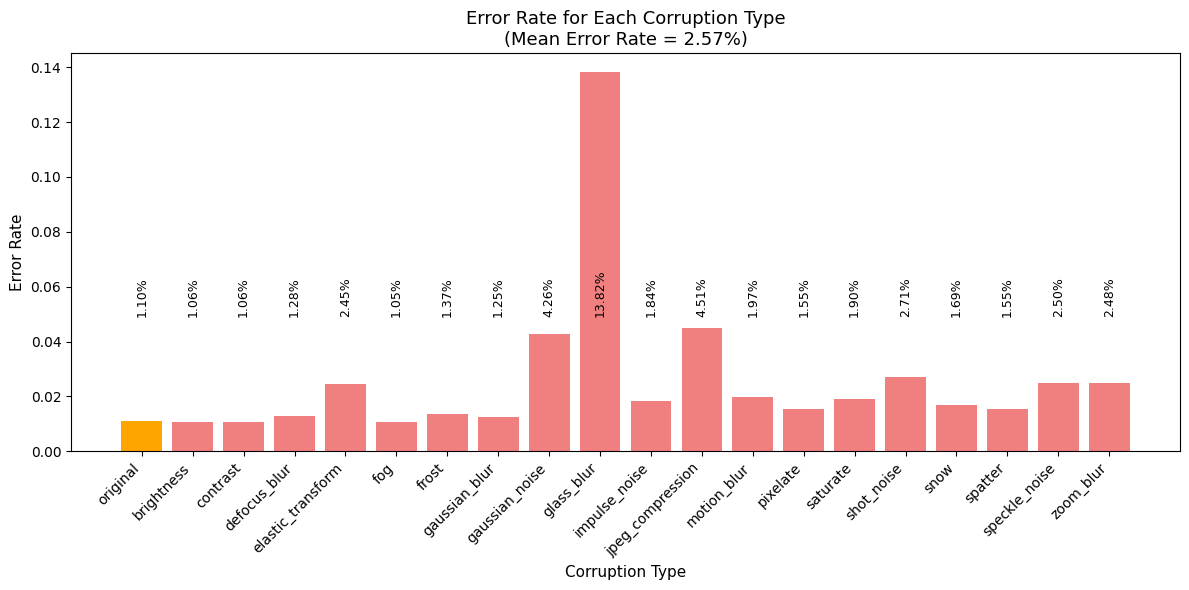

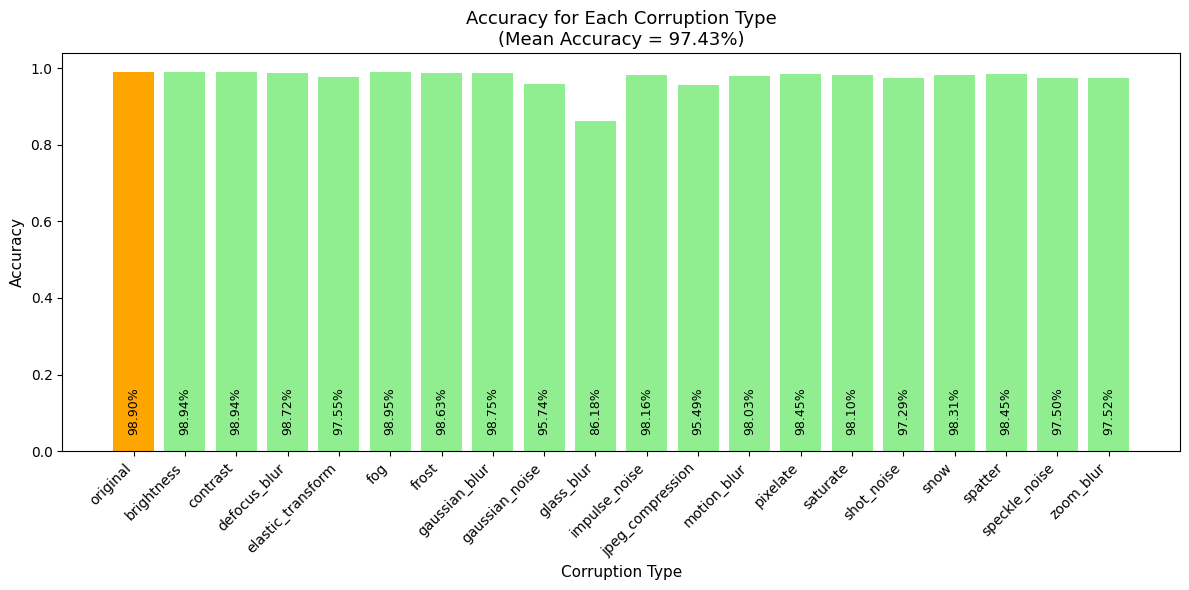

In [34]:
# Plot akurasi & error pengujian
def plot_metrics(metrics, metric_type):
    mean_metric = np.mean(list(metrics.values()))
    plt.figure(figsize=(12, 6))

    # Plot metrics
    c_types = [c_type.lower() for c_type in metrics.keys()]
    values = list(metrics.values())

    if metric_type == 'error':
        color = 'lightcoral'
        ylabel = 'Error Rate'
        title = 'Error Rate for Each Corruption Type\n(Mean Error Rate = {:.2f}%)'.format(mean_metric*100)
    elif metric_type == 'accuracy':
        color = 'lightgreen'
        ylabel = 'Accuracy'
        title = 'Accuracy for Each Corruption Type\n(Mean Accuracy = {:.2f}%)'.format(mean_metric*100)
    else:
        raise ValueError("Invalid metric_type. Please use 'error' or 'accuracy'.")
    colors = [color if key != 'original' else 'orange' for key in c_types]
    bars = plt.bar(c_types, values, color=colors)
    for bar, rate in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, 0.05, '{:.2f}%'.format(rate*100), ha='center', color='black', fontsize=9, rotation=90)
    plt.title(title, size=13)
    plt.xlabel('Corruption Type', size=11)
    plt.ylabel(ylabel, size=11)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{drive_path}{metric_type.lower()}_rate.png')
    plt.show()
c_type_acc = {c_type: 1 - error_rate for c_type, error_rate in c_type_errors.items()}
plot_metrics(c_type_errors, 'error')
plot_metrics(c_type_acc, 'accuracy')

In [35]:
NUM_EXAMPLES = 10000
SEVERITY = 5
DATADIR = "data"
SHUFFLE = False

Starting download from https://zenodo.org/api/records/2535967/files/CIFAR-10-C.tar/content


44533it [02:50, 261.35it/s]                           


Download finished, extracting...
Downloaded and extracted.


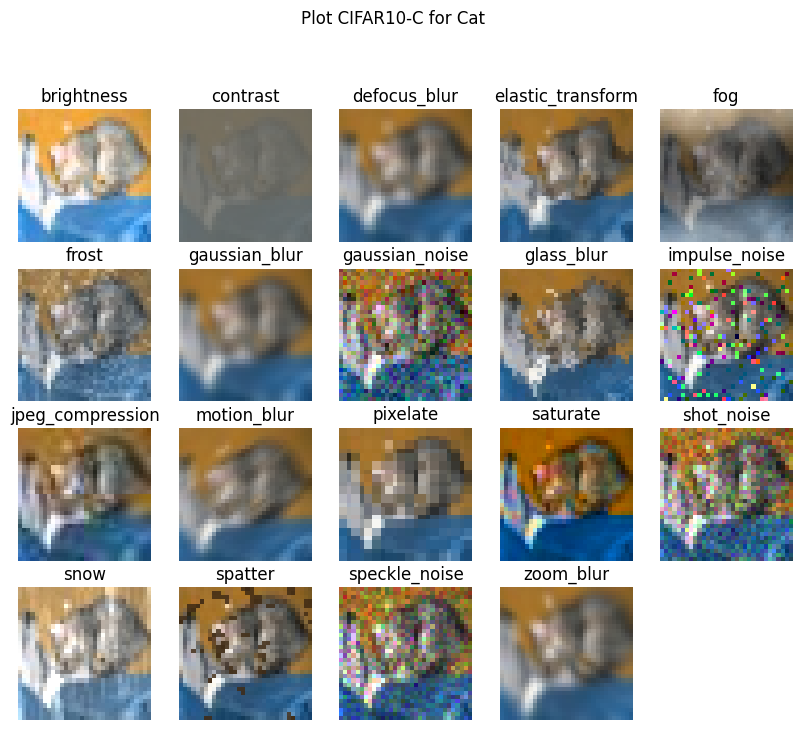

In [36]:
def plot_cifar10_c():
    x, y = load_cifar10c(
        len(corruption_types),
        SEVERITY, DATADIR, SHUFFLE,
        corruption_types
    )
    x_np = x.numpy()
    x_np = np.transpose(x_np, (0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)
    # Plot CIFAR-10-C images
    plt.figure(figsize=(10, 10))
    for i in range(len(corruption_types)):  # Plot the first 25 images
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_np[i])
        plt.title(f"{corruption_types[i]}")  # Show label
        plt.axis('off')

    plt.suptitle(f'Plot CIFAR10-C for Cat')
    plt.show()

plot_cifar10_c()

In [43]:
del net
del optimizer
del criterion

# Langkah 2: Bersihkan cache CUDA
torch.cuda.empty_cache()

# Langkah 3 (opsional tapi lebih agresif): Koleksi sampah dan clear
import gc
gc.collect()
torch.cuda.empty_cache()

In [44]:
# Buat ulang arsitektur model
print('==> Building model..')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Use CUDA' if torch.cuda.is_available() else 'Use CPU')

net = custom_model('vit_timm')
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

# Load checkpoint
checkpoint = torch.load(f'{drive_path}vit_timm_best_model.pth', map_location=device)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
best_acc = checkpoint['best_acc']
print(f"Model loaded, last accuracy: {best_acc:.2f}% at epoch {start_epoch}")

==> Building model..
Use CUDA
Model loaded, last accuracy: 98.90% at epoch 19


In [45]:
corruption_errors = {}

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define batch size for testing
test_batch_size = 16  # Adjust this value as needed

# Iterate over corrupted images one corruption at a time
for corruption_type in corruption_types:
    print("Corruption type: ", corruption_type)
    images, labels = load_cifar10c(NUM_EXAMPLES, SEVERITY, DATADIR, SHUFFLE, [corruption_type])

    correct = 0
    total = 0
    # Process images in batches
    for i in range(0, len(images), test_batch_size):
        batch_images = images[i:i+test_batch_size]
        batch_labels = labels[i:i+test_batch_size]

        batch_images = torch.stack([transform(image) for image in batch_images])
        batch_images = batch_images.to(device).float()
        batch_labels = batch_labels.to(device).float()

        outputs = net(batch_images)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    acc = 100 * correct / total
    corruption_errors[corruption_type] = 1-acc/100
    print(f'Accuracy of the network on {corruption_type} images: {acc}')

Corruption type:  brightness
Accuracy of the network on brightness images: 97.87
Corruption type:  contrast
Accuracy of the network on contrast images: 96.07
Corruption type:  defocus_blur
Accuracy of the network on defocus_blur images: 93.34
Corruption type:  elastic_transform
Accuracy of the network on elastic_transform images: 82.43
Corruption type:  fog
Accuracy of the network on fog images: 91.52
Corruption type:  frost
Accuracy of the network on frost images: 93.69
Corruption type:  gaussian_blur
Accuracy of the network on gaussian_blur images: 92.22
Corruption type:  gaussian_noise
Accuracy of the network on gaussian_noise images: 75.87
Corruption type:  glass_blur
Accuracy of the network on glass_blur images: 72.9
Corruption type:  impulse_noise
Accuracy of the network on impulse_noise images: 90.32
Corruption type:  jpeg_compression
Accuracy of the network on jpeg_compression images: 85.41
Corruption type:  motion_blur
Accuracy of the network on motion_blur images: 92.11
Corru

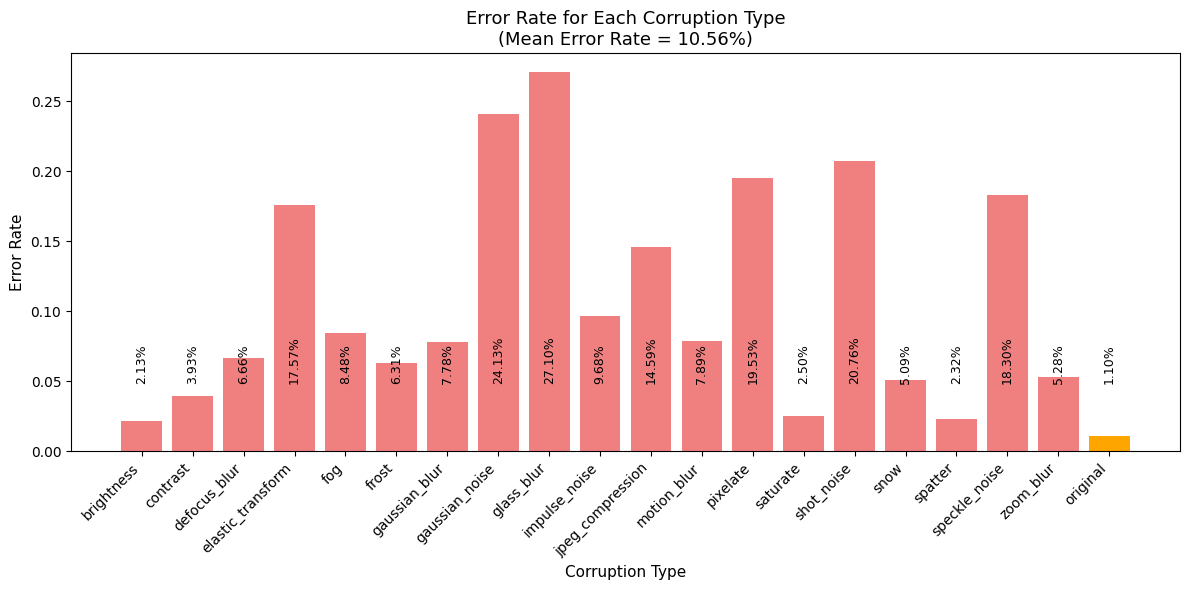

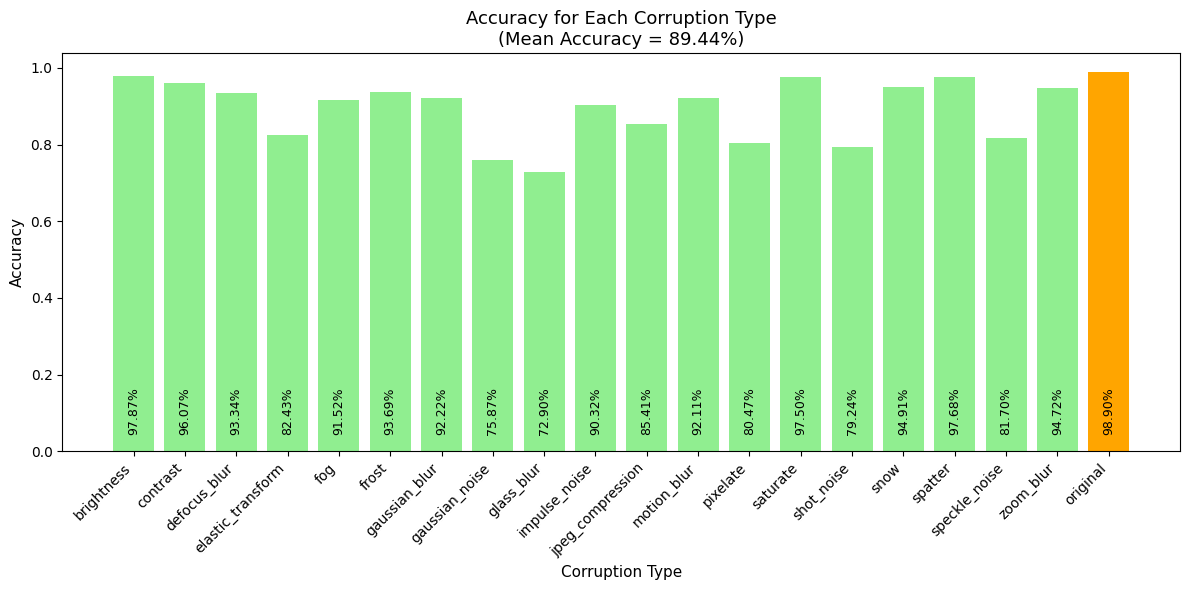

In [47]:
corruption_errors['original'] = c_type_errors['original']
# del corruption_errors['original']
corruption_acc = {c_type: 1 - error_rate for c_type, error_rate in corruption_errors.items()}
plot_metrics(corruption_errors, 'error')
plot_metrics(corruption_acc, 'accuracy')